# **Section:** Unbalance different size

In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

tiles = ["b234", "b360", "b278", "b261"]

In [3]:
%%time

path = "_data/s20k_scaled.pkl.bz2"


train_datas = {}

sample = pd.read_pickle(path)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = Container({k: v for k, v in sample.groupby("tile") if k in tiles})

del sample

REAL_SIZES = {'b234': 293013, 'b261': 555693, 'b278': 742153, 'b360': 939110}

CPU times: user 4.33 s, sys: 238 ms, total: 4.57 s
Wall time: 4.66 s


## Run the classifiers with the selected parameters

In [4]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [5]:
def get_combs(data, X_columns, nfolds):
    combs = []
    for idx, elem in enumerate(data.items()):
        tile, df = elem
        combs.append({
            "idx": idx,
            "tile": tile,
            "test_sample": df,
            "X_columns": X_columns,
            "y_column": "cls",
            "nfolds": nfolds})
    return combs
    

def execute_clf(idx, tile, test_sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = test_sample[X_columns].values
    y = test_sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = RandomForestClassifier(**RF_PARAMS)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "clf_name": "RF",
        "train_name": tile,
        "test_name": f"KFolds ({nfolds})",
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)})    
    return result

def train_and_run(data, X_columns):
    combs = get_combs(data, X_columns, 10)
    print("Combinaciones: {}".format(len(combs)))    
    with joblib.Parallel(n_jobs=-1) as jobs:
        results = jobs(
            joblib.delayed(execute_clf)(**p) for p in tqdm.tqdm(combs))
    return results

In [6]:
results = train_and_run(data, X_columns)

100%|██████████| 4/4 [00:00<00:00, 2734.67it/s]

Combinaciones: 4


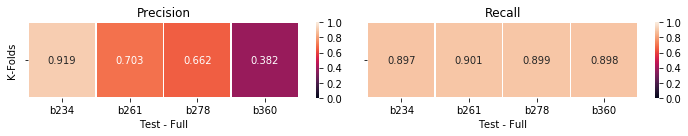

In [7]:
def as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Tile": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Tile")
    return df.T

def heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
#     return fix_precs
        
    fix_precs = as_df(fix_precs)
    fix_recall = as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test - Full")
    ax[0].set_title(u"Precision".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test - Full")
    ax[1].set_title(u"Recall".format(fp))


fig, axs = plt.subplots(1, 2, figsize=(10, 2))
heatmap(axs, results, 0.90)
axs[0].set_ylabel("K-Folds")

axs[0].set_yticklabels([""])
axs[1].set_yticklabels([""])
    
fig.tight_layout()
# fig.savefig(plot_path / "section_unbalanced_diffsize_prec_rec_heatmap.pdf")

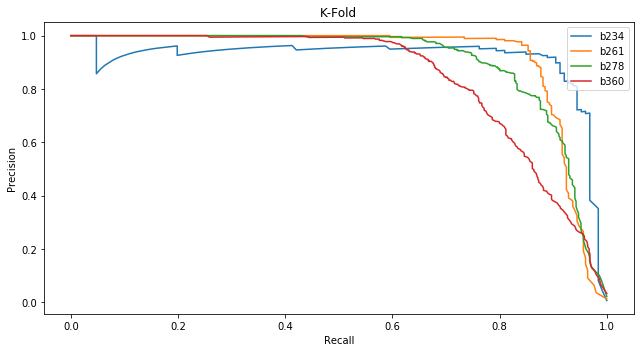

In [17]:
def plot_prec_roc_curve(ax, train_name, results):
    for r in results:
        if r.train_name == train_name:
            ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=train_name)
            break
    ax.set_title("K-Fold")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='upper right')

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for t in data.keys():
    plot_prec_roc_curve(ax, train_name=t, results=results)

fig.tight_layout()

In [ ]:
import datetime
datetime.datetime.now()